In [2]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import spacy
from spacy import displacy
import random
import matplotlib.pyplot as plt
import numpy
from collections import Counter
from scify.nlp import show_tabs, visualise_subtrees, visualise_doc, check_for_non_trees, construct_pattern
#construct_pattern doesn't work!!!!
import itertools #accumulate
from funcy import rcompose as thread
from funcy import tree_nodes, first, second, juxt
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
nlp = spacy.load("en_core_sci_lg")
def chunks(doc): return [chunk for chunk in doc.noun_chunks]

In [ ]:
from scify.utils.GNBR_preprocessing import get_data_and_distributions, parse_dep_path, clean_and_parse

In [10]:
#distributions, data = GNBR_prep()
data, distributions = get_data_and_distributions("../DATA/biomedrel/")

['A+', 'A+.ind', 'A-', 'A-.ind', 'B', 'B.ind', 'E+', 'E+.ind', 'E-', 'E-.ind', 'E', 'E.ind', 'N', 'N.ind', 'O', 'O.ind', 'K', 'K.ind', 'Z', 'Z.ind'] headers 
        chemical-gene
(A+) agonism, activation
(A-) antagonism, blocking
(B) binding, ligand (esp. receptors)
(E+) increases expression/production
(E-) decreases expression/production
(E) affects expression/production (neutral)
(N) inhibits
        


In [11]:
data[:2]

[{'pmid': '25640386',
  'sent': 'Similarly 18F-FDG-PET/CT had higher sensitivity and specificity in hormone_receptor -LRB- + -RRB- and -LRB- - -RRB- groups .',
  'ent1': '-',
  'ent1_offset': '1624,1625',
  'ent2': 'hormone_receptor',
  'ent2_offset': '1598,1614',
  'ent1_raw': '-',
  'ent2_raw': 'hormone receptor',
  'ent1_canonical': 'null',
  'ent2_canonical': '3164',
  'ent1_type': 'Chemical',
  'ent2_type': 'Gene',
  'dep': 'sensitivity|appos|START_ENTITY sensitivity|nmod|END_ENTITY'},
 {'pmid': '28560459',
  'sent': 'The purpose of the present study was to investigate the protective effect of the -1 receptor -LRB- Sig-1R -RRB- agonist -LRB- + -RRB- - pentazocin -LRB- PTZ -RRB- on pressure-induced apoptosis and death of human trabecular meshwork cells -LRB- hTMCs -RRB- .',
  'ent1': '+',
  'ent1_offset': '244,245',
  'ent2': 'Sig-1R',
  'ent2_offset': '227,233',
  'ent1_raw': '+',
  'ent2_raw': 'Sig-1R',
  'ent1_canonical': 'null',
  'ent2_canonical': '10280',
  'ent1_type': 'Chem

In [12]:
counter = Counter()
path_lengths = Counter()

for dep, values in distributions.items():
    counter[dep] = sum(list(values.values()))
    length = len(dep.split(" "))
    path_lengths[length] += 1

counter_data = Counter()

for d in data:
    counter_data[d["dep"].lower()] += 1
for k,v in counter.most_common(20):
    print(k, "\t\t\t\t", v)

start_entity|appos|inhibitor inhibitor|compound|end_entity 				 61702.0
synthase|compound|start_entity synthase|appos|end_entity 				 57993.0
inhibitor|appos|start_entity inhibitor|compound|end_entity 				 39135.0
start_entity|appos|inhibitor inhibitor|nmod|end_entity 				 34476.0
start_entity|appos|inhibitor inhibitor|amod|end_entity 				 32538.0
synthase|amod|start_entity synthase|appos|end_entity 				 32269.0
response|nmod|start_entity response|compound|end_entity 				 30035.0
receptor|amod|start_entity receptor|appos|end_entity 				 26321.0
inhibitor|appos|start_entity inhibitor|amod|end_entity 				 22824.0
transporter|compound|start_entity transporter|appos|end_entity 				 19879.0
receptor|compound|start_entity receptor|appos|end_entity 				 19085.0
inhibitors|amod|start_entity inhibitors|amod|end_entity 				 14603.0
gene|amod|start_entity gene|appos|end_entity 				 11449.0
inhibitor|nsubj|start_entity inhibitor|compound|end_entity 				 11267.0
inhibitor|nsubj|start_entity inhibit

In [13]:
for d in data[:4]:
    print()
    print(d["dep"])
    print("Entity 1: ", d["ent1"] , d["ent1_raw"])
    print("Entity 2: ", d["ent2"] , d["ent2_raw"])
    print(d["sent"])


sensitivity|appos|START_ENTITY sensitivity|nmod|END_ENTITY
Entity 1:  - -
Entity 2:  hormone_receptor hormone receptor
Similarly 18F-FDG-PET/CT had higher sensitivity and specificity in hormone_receptor -LRB- + -RRB- and -LRB- - -RRB- groups .

agonist|appos|START_ENTITY agonist|compound|receptor receptor|appos|END_ENTITY
Entity 1:  + +
Entity 2:  Sig-1R Sig-1R
The purpose of the present study was to investigate the protective effect of the -1 receptor -LRB- Sig-1R -RRB- agonist -LRB- + -RRB- - pentazocin -LRB- PTZ -RRB- on pressure-induced apoptosis and death of human trabecular meshwork cells -LRB- hTMCs -RRB- .

inhibition|dep|START_ENTITY inhibition|amod|END_ENTITY
Entity 1:  0,0-diethyl_0-4-nitrophenyl_phosphate 0,0-diethyl 0-4-nitrophenyl phosphate
Entity 2:  cholinesterase cholinesterase
It decreased by 51 % cholinesterase inhibition in the brain caused by i.p. injection of 2 mg of parathion/kg body weight but not that of an equitoxic dose -LRB- 0.5 mg/kg -RRB- of its active me

In [14]:
counter = Counter()
path_lengths = Counter()

for dep, values in distributions.items():
    counter[dep] = sum(list(values.values()))
    length = len(dep.split(" "))
    path_lengths[length] += 1

counter_data = Counter()

for d in data:
    counter_data[d["dep"].lower()] += 1

In [15]:
#most common patterns from distribution file
for k,v in counter.most_common(20):
    print(k, "\t\t\t\t", v)

start_entity|appos|inhibitor inhibitor|compound|end_entity 				 61702.0
synthase|compound|start_entity synthase|appos|end_entity 				 57993.0
inhibitor|appos|start_entity inhibitor|compound|end_entity 				 39135.0
start_entity|appos|inhibitor inhibitor|nmod|end_entity 				 34476.0
start_entity|appos|inhibitor inhibitor|amod|end_entity 				 32538.0
synthase|amod|start_entity synthase|appos|end_entity 				 32269.0
response|nmod|start_entity response|compound|end_entity 				 30035.0
receptor|amod|start_entity receptor|appos|end_entity 				 26321.0
inhibitor|appos|start_entity inhibitor|amod|end_entity 				 22824.0
transporter|compound|start_entity transporter|appos|end_entity 				 19879.0
receptor|compound|start_entity receptor|appos|end_entity 				 19085.0
inhibitors|amod|start_entity inhibitors|amod|end_entity 				 14603.0
gene|amod|start_entity gene|appos|end_entity 				 11449.0
inhibitor|nsubj|start_entity inhibitor|compound|end_entity 				 11267.0
inhibitor|nsubj|start_entity inhibit

In [16]:
#most common patterns from the data file
for k,v in counter_data.most_common(20):
    print(k, "\t\t\t\t", v)

start_entity|appos|inhibitor inhibitor|compound|end_entity 				 7310
start_entity|appos|inhibitor inhibitor|nmod|end_entity 				 5756
inhibitor|appos|start_entity inhibitor|compound|end_entity 				 4998
phosphorylation|amod|start_entity phosphorylation|nmod|end_entity 				 4909
start_entity|appos|inhibitor inhibitor|amod|end_entity 				 4658
sequence|amod|start_entity sequence|nmod|end_entity 				 3981
inhibitor|appos|start_entity inhibitor|amod|end_entity 				 3589
synthase|compound|start_entity synthase|appos|end_entity 				 3534
receptor|amod|start_entity receptor|appos|end_entity 				 3085
synthase|amod|start_entity synthase|appos|end_entity 				 2974
inhibitor|nsubj|start_entity inhibitor|nmod|end_entity 				 2826
receptor|compound|start_entity receptor|appos|end_entity 				 2544
gene|amod|start_entity gene|appos|end_entity 				 2069
inhibited|nsubj|start_entity inhibited|dobj|end_entity 				 2065
start_entity|appos|antagonist antagonist|compound|end_entity 				 2058
inhibitor|nsu

In [17]:
#frequencies for dependency paths with certain length
for length, freq in path_lengths.items():
    print(f"{freq} paths with length {length}")

174247 paths with length 3
169681 paths with length 5
221328 paths with length 4
10048 paths with length 9
99915 paths with length 6
51157 paths with length 7
45692 paths with length 2
23584 paths with length 8
3968 paths with length 10
486 paths with length 12
1431 paths with length 11
178 paths with length 13
44 paths with length 14
17 paths with length 15
4 paths with length 16
2 paths with length 17


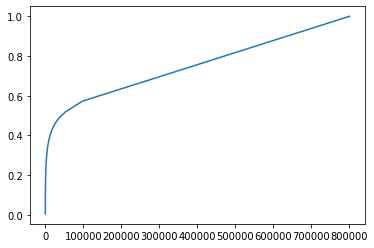

Top 10 patterns by freq account for 2.7225363823342073 % of the data.
Top 100 patterns by freq account for 8.639923078045152 % of the data.
Top 1000 patterns by freq account for 20.4608996270598 % of the data.
Top 10000 patterns by freq account for 38.12796905617442 % of the data.
Top 100000 patterns by freq account for 57.34636273904397 % of the data.
Top 500000 patterns by freq account for 81.65797931567663 % of the data.


In [18]:
values = sorted(list(counter_data.values()), reverse=True)
total = sum(values)
normalised = [x/total for x in values]
plt.plot(numpy.cumsum(normalised))
plt.show()


for k in [10, 100, 1000, 10000, 100000, 500000]:
    topk_patterns = {x[0] for x in counter_data.most_common(k)}
    topk_data = [x for x in data if x["dep"].lower() in topk_patterns]

    print(f"Top {k} patterns by freq account for {len(topk_data)/len(data) * 100} % of the data.")

In [19]:
#Do depenendcy tags line up with spacy?
# Check all of the possible dependency labels:

spacy_deps = {'ROOT', 'acl', 'acl:relcl','advcl','advmod','amod','appos','aux','auxpass','case','cc','cc:preconj','ccomp',
              'compound','compound:prt','conj','cop','csubj','csubjpass','dep','det','det:predet','dobj','expl','iobj','list',
              'mark','mwe','neg','nmod','nmod:npmod','nmod:poss','nmod:tmod','nsubj','nsubjpass','nummod','parataxis','punct','xcomp'}

dependencies = set()
for path in distributions.keys():
    triples = path.split(" ")
    for triple in triples:
        head, rel, tail = triple.split("|")
        dependencies.add(rel)
        
print("In both")
print(dependencies.intersection(spacy_deps))

print("In dep paths but not spacy")
print(dependencies.difference(spacy_deps))

print("In spacy but not dep paths")
print(spacy_deps.difference(dependencies))

# Conclusion:
# Need to fix: 
# 'nsubj:xsubj', 'nsubjpass:xsubj' => 'nsubj', 'nsubjpass'


In both
{'auxpass', 'acl:relcl', 'nmod:poss', 'appos', 'mark', 'nummod', 'ccomp', 'nmod', 'acl', 'iobj', 'neg', 'amod', 'nsubjpass', 'parataxis', 'nmod:tmod', 'compound:prt', 'aux', 'nmod:npmod', 'case', 'cc', 'xcomp', 'compound', 'dobj', 'det', 'dep', 'cop', 'list', 'csubjpass', 'nsubj', 'advmod', 'csubj', 'advcl'}
In dep paths but not spacy
{'discourse', 'ref', 'nsubjpass:xsubj', 'nsubj:xsubj'}
In spacy but not dep paths
{'expl', 'mwe', 'cc:preconj', 'conj', 'punct', 'det:predet', 'ROOT'}


In [21]:
example = "prevented|nsubj|START_ENTITY prevented|dobj|release release|nmod|END_ENTITY"
sent = "The ICE inhibitor Z-YVAD-FMK prevented the release of IL-1beta evoked by DNFB ."

# rules are of the form: A | governs (via relation) | B
# So for semregex we need A > B OR B < A, which might be better as spacy t.dep_ refers to the word's parent.

#  For this subtree, it looks like:
#                prevented
#       start_ent           release
#                                   end_entity

pattern = [
    {"SPEC": {"NODE_NAME": "prevented"}, "PATTERN": {"ORTH": "prevented"}},
    {"SPEC": {"NODE_NAME": "start_entity", "NBOR_RELOP": ">", "NBOR_NAME": "prevented"}, "PATTERN": {"DEP": "nsubj"}},
    {"SPEC": {"NODE_NAME": "release", "NBOR_RELOP": ">", "NBOR_NAME": "prevented"}, "PATTERN": {"DEP": "dobj", "ORTH":"release"}},
    {"SPEC": {"NODE_NAME": "end_entity", "NBOR_RELOP": ">", "NBOR_NAME": "release"}, "PATTERN": {"DEP": "nmod"}},
]

doc = nlp(sent)
visualise_doc(doc)
rules = [rule.split("|") for rule in example.split(" ")]
print(rules)
print()

[['prevented', 'nsubj', 'START_ENTITY'], ['prevented', 'dobj', 'release'], ['release', 'nmod', 'END_ENTITY']]



In [23]:
constructed_pattern = construct_pattern(rules)
matcher = DependencyMatcher(nlp.vocab)

matcher.add("pattern1", None, constructed_pattern)

matches = matcher(doc)
print(matches)
subtree = matches[0][1][0]

visualise_subtrees(doc, subtree)

[(13439661873955722336, [[4, 3, 6, 8]])]
Subtree:  [4, 3, 6, 8]


found 6929 matches (34.644999999999996 %)
Found 3263 patterns of length 2
Found 2092 patterns of length 3
Found 906 patterns of length 4
Found 193 patterns of length 6
Found 359 patterns of length 5
Found 82 patterns of length 7
Found 23 patterns of length 8
Found 2 patterns of length 11
Found 2 patterns of length 10
Found 6 patterns of length 9
Found 1 patterns of length 13
Found 3652 unique patterns

Top found patterns by freq:
domain|compound|start_entity domain|nmod|end_entity 			 154
inhibitor|appos|start_entity inhibitor|compound|end_entity 			 152
protein|compound|start_entity protein|nsubj|end_entity 			 113
fingers|compound|start_entity fingers|nmod|end_entity 			 113
factor|compound|start_entity factor|nsubj|end_entity 			 102
finger|compound|start_entity finger|nmod|end_entity 			 91
protein|compound|start_entity protein|appos|end_entity 			 66
gene|compound|start_entity gene|appos|end_entity 			 65
dismutase|compound|start_entity dismutase|appos|end_entity 			 62
finger|com

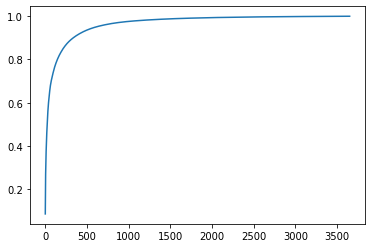

In [24]:

from spacy.tokens import Doc
from scispacy.util import WhitespaceTokenizer

nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

found = 0
pattern_lengths = defaultdict(int)
good_patterns = Counter()
examples = 20000
for d in data[-examples:]:
    subtree = parse_dep_path(d["dep"])
    
    pattern = construct_pattern(subtree)
    
    if pattern is None:
        continue
        
    doc = clean_and_parse(d["sent"], nlp)
    
    matcher = DependencyMatcher(nlp.vocab)
    matcher.add("pattern1", None, pattern)

    matches = matcher(doc)
               
    match = matches[0]
    if match[1]:
        found +=1
        pattern_lengths[len(subtree)] +=1
        good_patterns[d["dep"].lower()] +=1

print(f"found {found} matches ({found/examples  * 100} %)")
for k,v in pattern_lengths.items():
    print(f"Found {v} patterns of length {k}")
    
print(f"Found {len(good_patterns)} unique patterns")

print()
print("Top found patterns by freq:")
for k,v in good_patterns.most_common(50):
    print(k, "\t\t\t", v)

values = sorted([counter[p] for p in good_patterns.keys()], reverse=True)
total = sum(values)
normalised = [x/total for x in values]
plt.plot(numpy.cumsum(normalised))
plt.show()


In [25]:
len({d["dep"].lower() for d in data[-examples:]})
bad_pattern_data = [d for d in data[-examples:] if d["dep"].lower() not in good_patterns]

In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import random
random.shuffle(bad_pattern_data)
for d in bad_pattern_data[:1000]:
    
    if len(d["sent"].split(" ")) > 15:
        continue
    visualise_doc(clean_and_parse(d["sent"], nlp))
    print(d["dep"])
    print("Entity 1: ", d["ent1"] )
    print("Entity 2: ", d["ent2"] )    
    print()
    
# OBSERVATIONS:
# Check why this wasn't picked up
# A recent study T062 using mice T015 carrying a mutation T045 in a specific tyrosine T116 residue of trkB T116 pinpoints a necessary role for the phospholipase-Cgamma -LRB- T116 PLCgamma -RRB- pathway T044 in CREB activation T044 and LTP T042 maintenance T052 .
# residue|compound|START_ENTITY residue|nmod|END_ENTITY
# Entity 1:  tyrosine
# Entity 2:  trkB
#


# acl vs appos
# amods are often annotated as compound nouns - for amod, maybe allow compound IMPORTANT this will fix many examples
# dep => allow any edge, as the parse was wrong

# What happens if we throw away all relations and just use unlabeled edges?
# Some parsing errors come from weird attachments to brackets, what happens if we merge those tokens before using the abbreviation detector
# !!!! What is going wrong with punctuation parsing, should _always_ attach to root 
# ANSWER: dumb, this is because the sentences have line breaks at the end. dumb. This will fix many examples



based|nmod|START_ENTITY END_ENTITY|acl|based
Entity 1:  ZnO
Entity 2:  GaN



Effects|nmod|START_ENTITY Effects|nmod|activity activity|appos|END_ENTITY
Entity 1:  zinc
Entity 2:  OTC



fingers|compound|START_ENTITY contains|dobj|fingers contains|nmod|END_ENTITY
Entity 1:  zinc
Entity 2:  Staf



concentration-dependently|compound|START_ENTITY concentration-dependently|amod|END_ENTITY
Entity 1:  Y-27632
Entity 2:  Rho-kinase



fluorescence|amod|START_ENTITY fluorescence|amod|END_ENTITY
Entity 1:  Zinc
Entity 2:  cytochrome_c



oxidase|nsubj|START_ENTITY oxidase|xcomp|END_ENTITY
Entity 1:  Xanthine
Entity 2:  xanthine_dehydrogenase



depletion|compound|START_ENTITY Influence|nmod|depletion END_ENTITY|nsubj|Influence
Entity 1:  zinc
Entity 2:  growth_hormone



protection|nmod|START_ENTITY role|nmod|protection plays|dobj|role plays|nsubj|END_ENTITY
Entity 1:  Z-ligustilide
Entity 2:  HSP70



activation|compound|START_ENTITY induced|nsubj|activation inhibitors|dep|induced inhibitors|nsubj|END_ENTITY
Entity 1:  wortmannin
Entity 2:  PI3K



finger|compound|START_ENTITY END_ENTITY|appos|finger
Entity 1:  zinc
Entity 2:  Krox-20



treated|nmod|START_ENTITY treated|nsubj|END_ENTITY
Entity 1:  zidovudine
Entity 2:  erythropoietin



maps|compound|START_ENTITY maps|compound|END_ENTITY
Entity 1:  zinc
Entity 2:  ZNF2



START_ENTITY|acl:relcl|specific specific|nmod|END_ENTITY
Entity 1:  Z-Arg-Arg-MCA
Entity 2:  cathepsin_B



inhibitor|nsubj|START_ENTITY inhibitor|nmod|secretion secretion|appos|END_ENTITY
Entity 1:  WR-2721
Entity 2:  PTH



Efficacy|nmod|START_ENTITY recombinant|nsubj|Efficacy recombinant|dobj|END_ENTITY
Entity 1:  zinc
Entity 2:  insulin



START_ENTITY|nsubj|Influence Influence|nmod|suppressor suppressor|compound|END_ENTITY
Entity 1:  YM155
Entity 2:  survivin



combination|nmod|START_ENTITY increased|nsubj|combination increased|dobj|levels levels|amod|END_ENTITY
Entity 1:  Zn
Entity 2:  MT-I



protein|compound|START_ENTITY END_ENTITY|appos|protein
Entity 1:  zinc
Entity 2:  SmZF1



ions|compound|START_ENTITY play|nsubj|ions play|nmod|biosynthesis biosynthesis|nmod|END_ENTITY
Entity 1:  Zinc
Entity 2:  insulin



added|nsubjpass|START_ENTITY added|nmod|END_ENTITY
Entity 1:  ZAP-70-PE
Entity 2:  ZAP-70



factor|compound|START_ENTITY END_ENTITY|appos|factor
Entity 1:  zinc
Entity 2:  Lung_Kruppel-like_factor



protein|compound|START_ENTITY Cysteine-rich_intestinal_protein|dep|protein Cysteine-rich_intestinal_protein|appos|END_ENTITY
Entity 1:  zinc
Entity 2:  CRIP



protein|compound|START_ENTITY induces|nsubj|protein induces|advmod|END_ENTITY
Entity 1:  zinc
Entity 2:  GLI



START_ENTITY|appos|antagonist antagonist|amod|END_ENTITY
Entity 1:  zetidoline
Entity 2:  dopamine_D2_receptor



START_ENTITY|appos|inhibitor inhibitor|amod|END_ENTITY
Entity 1:  xanthohumol
Entity 2:  valosin-containing_protein



mixtures|compound|START_ENTITY END_ENTITY|dep|mixtures
Entity 1:  zinc
Entity 2:  insulin



inhibitor|dep|START_ENTITY inhibitor|nmod|END_ENTITY
Entity 1:  Z-Gly-ProCHN2
Entity 2:  PPCE



protein|compound|START_ENTITY Synthesis|nmod|protein Synthesis|appos|END_ENTITY
Entity 1:  zinc
Entity 2:  Zif268



protein|compound|START_ENTITY encodes|dobj|protein encodes|nsubj|Wig-1 Wig-1|nummod|END_ENTITY
Entity 1:  zinc
Entity 2:  p53



START_ENTITY|appos|inhibitor inhibitor|nmod|END_ENTITY
Entity 1:  Wortmannin
Entity 2:  PI_3-K



START_ENTITY|nmod|activation activation|amod|END_ENTITY
Entity 1:  Wogonin
Entity 2:  NFATc1



START_ENTITY|nsubj|effects effects|amod|END_ENTITY
Entity 1:  y-aminobutyric_acid
Entity 2:  Growth_hormone-releasing_hormone



Effect|nmod|START_ENTITY ions|nsubj|Effect ions|nmod|interaction interaction|nmod|protein protein|compound|END_ENTITY
Entity 1:  zinc
Entity 2:  S-100



decreases|dobj|START_ENTITY decreases|nsubj|ablation ablation|amod|END_ENTITY
Entity 1:  zinc
Entity 2:  Apolipoprotein_E



domain|compound|START_ENTITY lacking|dobj|domain END_ENTITY|acl|lacking
Entity 1:  zinc
Entity 2:  ARFGAP2



suppressed|nsubj|START_ENTITY suppressed|dobj|phosphorylation phosphorylation|amod|END_ENTITY
Entity 1:  ZD1839
Entity 2:  EGFR



START_ENTITY|appos|inhibitor inhibitor|compound|END_ENTITY
Entity 1:  Wortmannin
Entity 2:  PI3K



prevented|nsubj|START_ENTITY prevented|nmod|expression expression|amod|END_ENTITY
Entity 1:  zingerone
Entity 2:  PPAR



inhibitors|appos|START_ENTITY inhibitors|nummod|END_ENTITY
Entity 1:  wortmannin
Entity 2:  PI3K



uptake|compound|START_ENTITY role|nmod|uptake play|dobj|role play|nsubj|transporters transporters|compound|END_ENTITY
Entity 1:  zinc
Entity 2:  ZIP



fingers|compound|START_ENTITY domains|nsubj|fingers domains|xcomp|similar similar|nmod|those those|nmod|END_ENTITY
Entity 1:  zinc
Entity 2:  Sp1



prevented|nmod|START_ENTITY prevented|xcomp|pointing pointing|nmod|involvement involvement|nmod|END_ENTITY
Entity 1:  wortmannin
Entity 2:  PI3K



homeostasis|compound|START_ENTITY END_ENTITY|nmod|homeostasis
Entity 1:  zinc
Entity 2:  ZIP7



cultures|nmod|START_ENTITY Downregulation|nmod|cultures Downregulation|nmod|activity activity|amod|END_ENTITY
Entity 1:  yohimbine
Entity 2:  tyrosinase



caused|nmod|START_ENTITY END_ENTITY|acl|caused
Entity 1:  zebularine
Entity 2:  ARHI



possesses|nsubj|START_ENTITY possesses|dobj|property property|amod|END_ENTITY
Entity 1:  Y-25130
Entity 2:  5-HT3_receptor



START_ENTITY|appos|inhibitor inhibitor|amod|END_ENTITY
Entity 1:  zileuton
Entity 2:  5-lipoxygenase



inhibits|nsubj|START_ENTITY inhibits|ccomp|stem stem|dobj|cells cells|nmod|repression repression|nmod|END_ENTITY
Entity 1:  XAV939
Entity 2:  tankyrase_1



receiving|dobj|START_ENTITY Recombinant|advcl|receiving Recombinant|dobj|END_ENTITY
Entity 1:  zidovudine
Entity 2:  erythropoietin



attenuated|nsubj|START_ENTITY attenuated|dobj|phosphorylation phosphorylation|nmod|kinase kinase|amod|END_ENTITY
Entity 1:  Y27632
Entity 2:  p38



induction|nmod|START_ENTITY induction|nsubj|END_ENTITY
Entity 1:  zinc
Entity 2:  Ceruloplasmin



effect|nmod|START_ENTITY Evidence|nmod|effect Evidence|nmod|involvement involvement|nmod|END_ENTITY
Entity 1:  zinc
Entity 2:  heme_oxygenase-1



START_ENTITY|nsubj|production production|nmod|END_ENTITY
Entity 1:  Xanthurenic_acid
Entity 2:  IL-10



START_ENTITY|appos|inhibitor inhibitor|amod|END_ENTITY
Entity 1:  Y-27632
Entity 2:  Rho-kinase



inhibitors|dep|START_ENTITY inhibitors|amod|END_ENTITY
Entity 1:  zanamivir
Entity 2:  Neuraminidase



influence|nsubj:xsubj|START_ENTITY influence|dobj|secretion secretion|compound|END_ENTITY
Entity 1:  zinc
Entity 2:  prolactin



expression|nmod|START_ENTITY expression|amod|END_ENTITY
Entity 1:  YM511
Entity 2:  IGF-I



START_ENTITY|appos|inhibitor inhibitor|compound|END_ENTITY
Entity 1:  XR9051
Entity 2:  P-gp



pretreatment|nmod|START_ENTITY reduced|nsubj|pretreatment reduced|nmod|END_ENTITY
Entity 1:  wortmannin
Entity 2:  thrombin



transport|amod|START_ENTITY transport|nmod|END_ENTITY
Entity 1:  Zinc
Entity 2:  transferrin



START_ENTITY|appos|inhibitor inhibitor|compound|END_ENTITY
Entity 1:  wortmannin
Entity 2:  PI3K



inhibitor|nsubj|START_ENTITY inhibitor|nmod|HER2 HER2|compound|END_ENTITY
Entity 1:  XL647
Entity 2:  EGFR



levels|amod|START_ENTITY levels|nmod|END_ENTITY
Entity 1:  Zinc
Entity 2:  insulin



induction|nmod|START_ENTITY induction|amod|END_ENTITY
Entity 1:  WR-1065
Entity 2:  VEGF-A



infusion|amod|START_ENTITY concentrations|nmod|infusion concentrations|compound|END_ENTITY
Entity 1:  xylitol
Entity 2:  insulin



Plasma|nummod|START_ENTITY Plasma|nummod|END_ENTITY
Entity 1:  zinc
Entity 2:  interleukin-6



START_ENTITY|dep|inhibitor inhibitor|compound|END_ENTITY
Entity 1:  Zanamivir
Entity 2:  neuraminidase



START_ENTITY|nsubj|mediates mediates|amod|END_ENTITY
Entity 1:  zinc
Entity 2:  NADPH_oxidase-2



START_ENTITY|appos|inhibitor inhibitor|compound|END_ENTITY
Entity 1:  YM-21095
Entity 2:  renin



domains|compound|START_ENTITY mediated|nmod|domains mediated|nsubj|Self-association Self-association|nmod|END_ENTITY
Entity 1:  zinc
Entity 2:  GATA-1



toxicity|compound|START_ENTITY END_ENTITY|nmod|toxicity
Entity 1:  zinc
Entity 2:  HIF-1alpha



increased|nmod|START_ENTITY increased|nsubjpass|activity activity|amod|END_ENTITY
Entity 1:  xanthohumol
Entity 2:  caspase-3



induces|nsubj|START_ENTITY induces|dobj|expression expression|nmod|presence presence|nmod|END_ENTITY
Entity 1:  WR1065
Entity 2:  p53



START_ENTITY|nsubj:xsubj|influence influence|nmod|END_ENTITY
Entity 1:  zearalenone
Entity 2:  N-acetyl-l-cysteine



gene|compound|START_ENTITY suppresses|nsubj|gene suppresses|dobj|END_ENTITY
Entity 1:  zinc
Entity 2:  p53



motif|amod|START_ENTITY contains|dobj|motif contains|nsubj|sequence sequence|amod|END_ENTITY
Entity 1:  zinc
Entity 2:  Vps18p



START_ENTITY|dep|misfolding misfolding|compound|END_ENTITY
Entity 1:  zinc
Entity 2:  p53



transporter|compound|START_ENTITY END_ENTITY|appos|transporter
Entity 1:  zinc
Entity 2:  ZnT7



administration|compound|START_ENTITY activity|nmod|administration activity|compound|END_ENTITY
Entity 1:  Zn-PP
Entity 2:  HO-1



In [27]:
good_patterns

Counter({'up-regulates|nsubj|start_entity up-regulates|dobj|end_entity': 1,
         'enhances|nsubj|start_entity enhances|nmod|up-regulation up-regulation|nmod|end_entity': 1,
         'enhanced|nsubj|start_entity enhanced|dobj|end_entity': 1,
         'effects|nmod|start_entity diminished|dobj|effects diminished|nsubj|silencing silencing|nmod|end_entity': 1,
         'effect|nmod|start_entity abolished|dobj|effect abolished|nsubj|knock-down knock-down|nmod|end_entity': 1,
         'inhibited|nsubj|start_entity inhibited|dobj|end_entity': 37,
         'effects|nmod|start_entity reversed|dobj|effects reversed|nsubj|inhibition inhibition|nmod|end_entity': 1,
         'suppressed|nsubj|start_entity suppressed|dobj|activity activity|compound|end_entity': 2,
         'decreased|nsubj|start_entity decreased|dobj|amount amount|nmod|end_entity': 2,
         'inhibited|nsubj|start_entity inhibited|dobj|phosphorylation phosphorylation|nmod|end_entity': 21,
         'effects|nmod|start_entity ex